# Notebook 2: Define the Convolutional Neural Network and training the network



##1. CNN Architecture

* Defined in `models.py` file.

---

###2. Loading the data and necessary imports

In [1]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data
#imports
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


Streaming output truncated to the last 5000 lines.
  inflating: /data/test/Elmar_Brok_30.jpg  
  inflating: /data/test/Elmar_Brok_31.jpg  
  inflating: /data/test/Elsa_Zylberstein_00.jpg  
  inflating: /data/test/Elsa_Zylberstein_01.jpg  
  inflating: /data/test/Elsa_Zylberstein_10.jpg  
  inflating: /data/test/Elsa_Zylberstein_11.jpg  
  inflating: /data/test/Elsa_Zylberstein_40.jpg  
  inflating: /data/test/Elsa_Zylberstein_41.jpg  
  inflating: /data/test/Elton_John_10.jpg  
  inflating: /data/test/Elton_John_11.jpg  
  inflating: /data/test/Elton_John_20.jpg  
  inflating: /data/test/Elton_John_21.jpg  
  inflating: /data/test/Elton_John_30.jpg  
  inflating: /data/test/Elton_John_31.jpg  
  inflating: /data/test/Elton_John_40.jpg  
  inflating: /data/test/Elton_John_41.jpg  
  inflating: /data/test/Emile_Lahoud_00.jpg  
  inflating: /data/test/Emile_Lahoud_01.jpg  
  inflating: /data/test/Emile_Lahoud_30.jpg  
  inflating: /data/test/Emile_Lahoud_31.jpg  
  inflating: /data/test/E

### 3. Loading the Model

In [8]:
from models import Net
net = Net()
from torchsummary import summary   #can get summary of model
net.to('cuda')
summary(net, input_size=(1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 222, 222]              80
         MaxPool2d-2          [-1, 8, 111, 111]               0
           Dropout-3          [-1, 8, 111, 111]               0
            Conv2d-4         [-1, 64, 109, 109]           4,672
         MaxPool2d-5           [-1, 64, 54, 54]               0
           Dropout-6           [-1, 64, 54, 54]               0
            Conv2d-7          [-1, 128, 50, 50]         204,928
         MaxPool2d-8          [-1, 128, 25, 25]               0
           Dropout-9          [-1, 128, 25, 25]               0
           Conv2d-10          [-1, 256, 21, 21]         819,456
        MaxPool2d-11          [-1, 256, 10, 10]               0
          Dropout-12          [-1, 256, 10, 10]               0
           Linear-13                 [-1, 5000]     128,005,000
          Dropout-14                 [-

### 4. Loading the Dataset and transforming it

1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`,

In [9]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [10]:
# the dataset created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
from data_load import Rescale, RandomCrop, Normalize, ToTensor
data_transform = transforms.Compose([Rescale(230), RandomCrop(224), Normalize(), ToTensor()])

In [11]:
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)

print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


### 4. Batching and loading data

In [12]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)


###4. Load in the test dataset and test untrained model


In [13]:
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)
# load test data in batches
batch_size = 10
test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

#### Apply the model on a test sample


In [14]:
# returns: test images, test predicted keypoints, test ground truth keypoints
def net_sample_output():
  
    for i, sample in enumerate(test_loader):
        images = sample['image']
        key_pts = sample['keypoints']
        images = images.type(torch.FloatTensor)   #convert images to FloatTensors ,images recieved will be of type tensor
        output_pts = net(images)
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        if i == 0:
            return images, output_pts, key_pts    

In [18]:
test_images, test_outputs, gt_pts = net_sample_output()   # test_images is a 10 batch of images tensor
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


#### Visualize the predicted keypoints
* Will have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [19]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')

#### Un-transformation

`visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

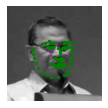

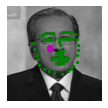

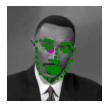

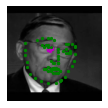

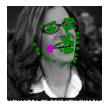

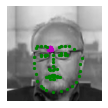

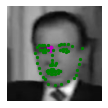

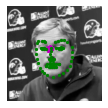

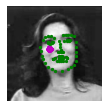

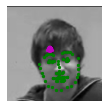

In [20]:
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts) 
        plt.axis('off')
    plt.show()
# call it
visualize_output(test_images, test_outputs, gt_pts)

###5. Training


---

In [21]:
import torch.optim as optim
criterion = nn.MSELoss()
optimizer = optim.Adam(params = net.parameters())
net.to('cuda')

Net(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25600, out_features=5000, bias=True)
  (cl_drop): Dropout(p=0.4, inplace=False)
  (fc1_drop): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=5000, out_features=500, bias=True)
  (fc2_drop): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=500, out_features=136, bias=True)
)

In [22]:
def train_net(n_epochs):
    net.train()
    for epoch in range(n_epochs):  
        running_loss = 0.0
        for batch_i, data in enumerate(train_loader):
            images = data['image']
            key_pts = data['keypoints']
            
            images, key_pts = images.to('cuda'), key_pts.to('cuda')
            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)  #
            
            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.cuda.FloatTensor)
            images = images.type(torch.cuda.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0

    print('Finished Training')


In [23]:
n_epochs = 2
train_net(n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 1.1878415673971177
Epoch: 1, Batch: 20, Avg. Loss: 0.19028635323047638
Epoch: 1, Batch: 30, Avg. Loss: 0.1616683065891266
Epoch: 1, Batch: 40, Avg. Loss: 0.14035865440964698
Epoch: 1, Batch: 50, Avg. Loss: 0.13444502428174018
Epoch: 1, Batch: 60, Avg. Loss: 0.1464299477636814
Epoch: 1, Batch: 70, Avg. Loss: 0.1441470667719841
Epoch: 1, Batch: 80, Avg. Loss: 0.13682607635855676
Epoch: 1, Batch: 90, Avg. Loss: 0.1346083477139473
Epoch: 1, Batch: 100, Avg. Loss: 0.14232590720057486
Epoch: 1, Batch: 110, Avg. Loss: 0.1680807076394558
Epoch: 1, Batch: 120, Avg. Loss: 0.13088507503271102
Epoch: 1, Batch: 130, Avg. Loss: 0.1389497399330139
Epoch: 1, Batch: 140, Avg. Loss: 0.1524328738451004
Epoch: 1, Batch: 150, Avg. Loss: 0.12218657284975051
Epoch: 1, Batch: 160, Avg. Loss: 0.12921159192919732
Epoch: 1, Batch: 170, Avg. Loss: 0.12443837039172649
Epoch: 1, Batch: 180, Avg. Loss: 0.18193541169166566
Epoch: 1, Batch: 190, Avg. Loss: 0.14380694180727005
Epoch: 1, 

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [26]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


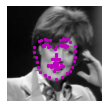

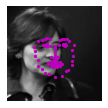

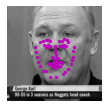

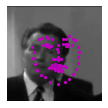

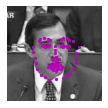

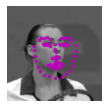

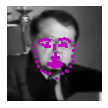

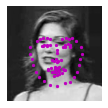

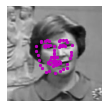

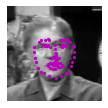

In [27]:
#10 epochs
visualize_output(test_images, test_outputs)

In [29]:
model_dir = '/content/'
model_name = 'keypoints_model_2_epoch'
torch.save(net.state_dict(), model_dir+model_name)

## Feature Visualization


[[ 0.27478626  0.08098705  0.05829286]
 [ 0.31069568  0.20551446  0.08169428]
 [ 0.26134196 -0.23921086 -0.07697757]]
(3, 3)


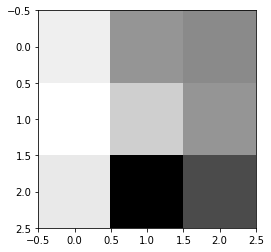

In [30]:
# eights in the first conv layer, "conv1"
weights2 = net.conv1.weight.data

w = weights2.numpy()

filter_index = 2

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

![alt text](https://github.com/varangrai/Udacity-CVND-Projects/blob/master/Facial%20Keypoints/images/feature_map_ex.png?raw=true)


### Filter an image to see the effect of a convolutional kernel
---

(224, 224)


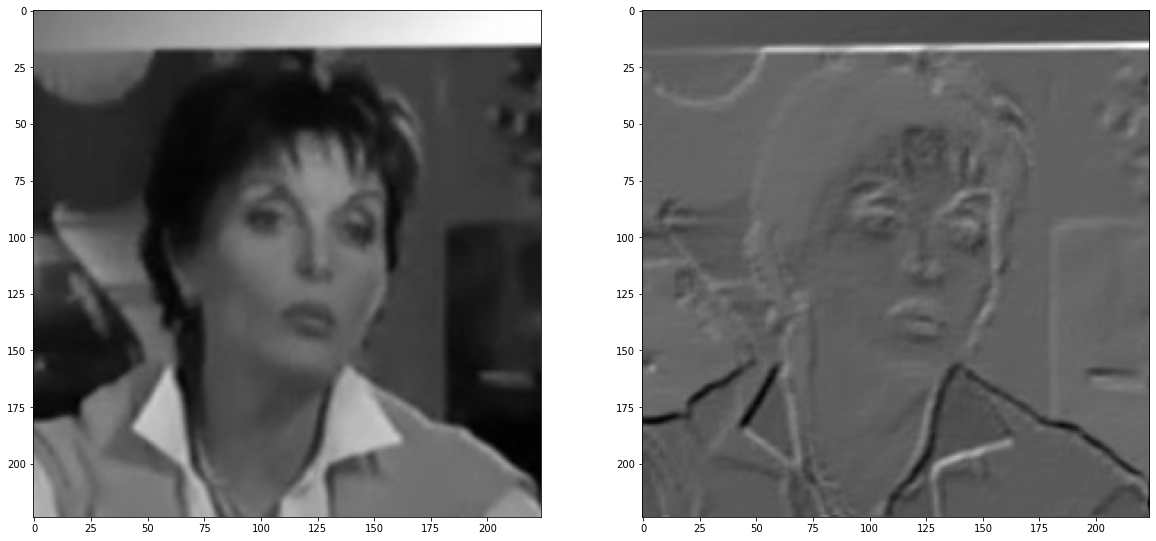

In [49]:
import cv2
# 1. first conv layer
# 8 filters in 1st layer
image_test = next(iter(test_loader))
image_test = image_test['image'][0].numpy()
fig=plt.figure(figsize=(20, 10))
fig.add_subplot(1, 2, 1)
image_test = image_test.reshape(224,224)
plt.imshow(image_test, cmap ='gray')
print(image_test.shape)
#plt.imshow(image_test, cmap = 'gray')
weights = net.conv1.weight.data
w = weights.numpy()
fig.add_subplot(1, 2, 2)
c = cv2.filter2D(image_test, -1, w[3][0])
plt.imshow(c, cmap='gray')